<a href="https://colab.research.google.com/github/no1rabbit/Cloud_chasing/blob/main/average_heading_cloudcover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration of the rainfall images

In [1]:
!pip install Windrose dash

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from windrose import WindroseAxes
import ipywidgets as widgets
from calendar import month
from tqdm import tqdm
from scipy.ndimage import rotate
from collections import defaultdict
import dash
from dash import dcc, html
from IPython.display import display
import plotly.graph_objs as go

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define paths to your data
gps_file = '/content/drive/MyDrive/Cloud data/Serengeti_HMM.csv'
#gps_file = 'data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['year'] = gps_data['date1'].dt.year
gps_data['month'] = gps_data['date1'].dt.month
gps_data = gps_data.sort_values(by=['ID','date'])




Load rainfall data and plot monthly means over years

In [5]:
## Load rainfall data
rain = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
#rain = xr.open_dataset('data/Serengeti_chirps_wide.nc')
#threshold = 10
#rain = rain.where(rain['rainfall'] <= threshold, 0)  # Set values below threshold to 0
#rain = rain.where(rain >= threshold, other=np.nan)

# Resample to monthly frequency
#monthly_ds = rain.resample(time='1M').mean()

# Print the resulting dataset
#print(monthly_ds)
#monthly_ds.rainfall.plot(col='time', col_wrap=12)

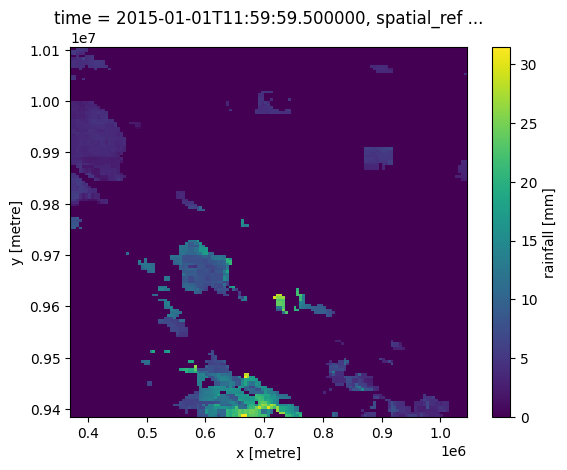

In [6]:
rain.isel(time=0).rainfall.plot()

Extract the images per individual at 32 x 32 pixels per image. The image is centered around the known GPS of the individual.   

In [7]:
image_size = 16
step = 1
lag = 1

# Create an empty array to store image-GPS pairs
xdata = np.zeros((len(gps_data),image_size,image_size,lag))
ydata = np.zeros((len(gps_data),2))
heading = np.zeros(len(gps_data))
years = np.zeros(len(gps_data))
months = np.zeros(len(gps_data))
doy = np.zeros(len(gps_data))
id_dtype = 'U10'
ids = np.empty(len(gps_data), dtype=id_dtype)

i=0
for uid in tqdm(gps_data['ID'].unique()):
    current_data = gps_data[gps_data['ID'] == uid]
    # iterate through every other row
    for index, row in current_data.iterrows():
        # Extract the unique identifier for the current row
        ids[i] = uid

        # if index % step != 0:
        #     continue

        # Extract GPS coordinates and time from the DataFrame
        center_x = row['x1_']
        center_y = row['y1_']
        center_date = row['date1']
        # find the row that is step days later
        next_date = center_date + pd.Timedelta(days=step)
        next_data = current_data[current_data['date1'] == next_date]
        if len(next_data) == 0:
            continue
        next_x = next_data['x1_'].values[0]
        next_y = next_data['y1_'].values[0]

        # Calculate the heading direction from the current location to the next location
        heading[i] = np.arctan2(next_y - center_y, next_x - center_x)
        heading[i] = np.mod(np.degrees(heading[i]), 360)
        # 0 degrees should be north, but the heading is calculated as 0 degrees being east
        heading[i] = np.mod(90 - heading[i], 360)

        ydata[i] = [next_x - center_x, next_y - center_y]

        # Convert latitude and longitude to indices in the xarray dataset
        x_index = np.abs(rain.x - center_x).argmin().values
        y_index = np.abs(rain.y - center_y).argmin().values

        # Find the index corresponding to the center_time in the time dimension
        time_index = np.abs(rain.time - np.datetime64(center_date)).argmin().values
        if time_index - lag < 0:
            continue

        # Extract a subset of the dataset centered around the specified location for 1 week starting at the current time
        subset = rain.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                            y=slice(y_index - image_size//2, y_index + image_size//2),
                            time=slice(time_index - lag + 1, time_index+1))

        # Extract the 2D array of the variable you want to visualize
        data_array = subset.rainfall.values

        # Check for NaN and infinite values
        #if np.isnan(data_array).any() or np.isinf(data_array).any():
         #   print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
          #  print(f"NaN values: {np.sum(np.isnan(data_array))}")
           # print(f"Infinite values: {np.sum(np.isinf(data_array))}")

        # Handle invalid values by replacing NaN and infinite values with 0
        # normalized_data = np.nan_to_num((data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array)))
        #data_array = np.nan_to_num(data_array)

        # data_array = np.mean(data_array,axis=0)
        data_array = np.transpose(data_array,[1,2,0])
        xdata[i] = data_array #np.reshape(data_array, (image_size, image_size, 1))
        years[i] = center_date.year
        months[i] = center_date.month
        doy[i] = center_date.dayofyear
        i += 1


##
print(i)
xdata = xdata[:i]
ydata = ydata[:i]
years = years[:i]
months = months[:i]
heading = heading[:i]
doy = doy[:i]
ids = ids[:i]

xdata = xdata.astype('float32')
years = years.astype('int32')
months = months.astype('int32')
doy = doy.astype('int32')
#xdata = xdata / np.percentile(xdata,95) #remove outliers
ydata = ydata.astype('float32')
#ydata = ydata / np.linalg.norm(ydata,axis=1,keepdims=True)
#heading = np.degrees(heading)
##

100%|██████████| 59/59 [04:19<00:00,  4.41s/it]

31390


The maximum and minimum rainfall per image

In [ ]:
print(np.max(xdata))
print(np.min(xdata))

Calculate the heading in degrees and rotate the images and heading of each individual to face north.

In [ ]:
# Calculate the difference between the true heading and 0 degrees (north)
heading_difference = 0 - heading

# Rotate the heading array to align with 0 degrees (north)
heading_aligned = np.mod(heading + heading_difference, 360)

#rxdata = np.zeros((len(gps_data),image_size,image_size,lag))

# Rotate the image data
for i in range(len(xdata)):
    xdata[i] = rotate(xdata[i], -heading_difference[i], reshape=False)


Plot the rotated image and the heading of the individual so make sure it's travelling north.

In [ ]:
# Function to plot rainfall for a specific individual, year, and day of the year
def plot_individual_rainfall(individual_id, year, day_of_year):
    plt.figure(figsize=(5, 3))
    # Check if data exists for the selected individual, year, and day of the year
    mask = (ids == individual_id) & (years == year) & (doy == day_of_year)
    if np.sum(mask) == 0:
        plt.text(0.5, 0.5, 'No data available', ha='center', va='center', fontsize=14, color='red')
        plt.axis('off')
    else:
        individual_data = xdata[mask]
        plt.imshow(individual_data.mean(axis=0), cmap='viridis')  # Plot average rainfall
        plt.scatter(16, 16, marker='x', color='red')
        plt.title(f'Average Rainfall for Individual {individual_id}, {year}-{day_of_year}')
        plt.colorbar()
    plt.show()

# Function to plot windrose for a specific individual, year, and day of the year
def plot_individual_windrose(individual_id, year, day_of_year):
    plt.figure(figsize=(6, 4))
    # Check if data exists for the selected individual, year, and day of the year
    mask = (ids == individual_id) & (years == year) & (doy == day_of_year)
    if np.sum(mask) == 0:
        plt.text(0.5, 0.5, 'No data available', ha='center', va='center', fontsize=14, color='red')
        plt.axis('off')
    else:
        individual_headings = heading_aligned[mask]
        ax = WindroseAxes.from_ax(figsize=(6, 4))
        ax.bar(individual_headings, var=np.ones_like(individual_headings), bins=np.arange(0, 360, 10), normed=True, opening=0.8, edgecolor='white')
        ax.set_title(f'Windrose Plot for Individual {individual_id}, {year}-{day_of_year}')
    plt.show()

# Get unique individual IDs, years, and days of the year
individual_ids = np.unique(ids).tolist()
years_list = np.unique(years).tolist()
days_of_year_list = np.unique(doy).tolist()

# Create dropdown widgets to select individual, year, and day of the year
individual_dropdown = widgets.Dropdown(options=individual_ids, description='Individual ID')
year_dropdown = widgets.Dropdown(options=years_list, description='Year')
day_of_year_dropdown = widgets.Dropdown(options=days_of_year_list, description='Day of Year')

# Create interactive widgets
widgets.interact(plot_individual_rainfall, individual_id=individual_dropdown, year=year_dropdown, day_of_year=day_of_year_dropdown)
widgets.interact(plot_individual_windrose, individual_id=individual_dropdown, year=year_dropdown, day_of_year=day_of_year_dropdown)




Plot the above images averaged per month

In [ ]:
# Step 1: Calculate the average rain per month for each year
average_rain_per_month = {}
for year in np.unique(years):
    for month in range(1, 13):
        mask = (years == year) & (months == month)
        monthly_rain = xdata[mask].mean(axis=0)
        if year not in average_rain_per_month:
            average_rain_per_month[year] = {}
        average_rain_per_month[year][month] = monthly_rain

# Step 1: Calculate the overall minimum and maximum rainfall values
min_rainfall = np.min(xdata)
max_rainfall = np.max(xdata)

# Step 2: Create rasters of average rain per month for each year
def plot_rainfall(year, month):
    plt.figure(figsize=(5, 3))  # Adjust the figure size here
    plt.imshow(average_rain_per_month[year][month], cmap='viridis')#, vmin=min_rainfall, vmax=max_rainfall)  # Set colorbar limits
    plt.title(f'Average Rainfall for {year}-{month}')
    plt.colorbar()
    plt.show()

# Step 3: Create windrose plot for heading directions
def plot_windrose(year, month):
    #plt.figure(figsize=(5, 3))
    indices = np.where((years == year) & (months == month))[0]
    month_headings = heading_aligned[indices]
    ax = WindroseAxes.from_ax(figsize=(6, 4))
    ax.bar(month_headings, var=np.ones_like(month_headings), bins=np.arange(0, 360, 10), normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'Windrose Plot for {year}-{month}')
    plt.show()

# Create interactive widgets
year_slider = widgets.IntSlider(value=min(years), min=min(years), max=max(years), description='Year')
month_slider = widgets.IntSlider(value=1, min=1, max=12, description='Month')

widgets.interact(plot_rainfall, year=year_slider, month=month_slider)
widgets.interact(plot_windrose, year=year_slider, month=month_slider)

Create a v mask to select all pixels in the heading direction of the animal

In [ ]:
# Create a circle mask
circle_mask = np.zeros((image_size, image_size))

# Calculate the center of the circle
center_x = image_size // 2
center_y = image_size // 2

# Calculate the radius of the circle
radius = 16  # Half of the diameter (16/2)

# Set pixels for the circle
y, x = np.ogrid[-center_y:image_size-center_y, -center_x:image_size-center_x]
mask = x**2 + y**2 <= radius**2
circle_mask[mask] = 1


# Visualize the combined mask
plt.imshow(circle_mask, cmap='gray')
plt.title('Circle Mask')
plt.colorbar()
plt.show()


In [ ]:
# Create a circle mask
circle_mask = np.zeros((image_size, image_size))

# Calculate the center of the circle
center_x = image_size // 2
center_y = image_size // 2

# Calculate the radius of the circle
radius = image_size/2  # Half of the diameter (16/2)

# Set pixels for the circle
y, x = np.ogrid[-center_y:image_size-center_y, -center_x:image_size-center_x]
mask = x**2 + y**2 <= radius**2
circle_mask[mask] = 1

# Create a "V" shape mask
v_mask = np.zeros((image_size, image_size))

# Determine the vertical center
center_y = image_size // 2

# Set pixels for the "V" shape
for i in range(center_y, image_size):
    v_mask[i, center_y - (i - center_y):center_y + (i - center_y) + 1] = 1

# Flip the "V" shape mask vertically
v_mask = np.flipud(v_mask)

# Apply circle mask to remove areas outside the circle
circle_v_mask = np.multiply(circle_mask, v_mask)

# Visualize the combined mask
plt.imshow(circle_v_mask, cmap='gray')
plt.title('Combined Mask')
plt.colorbar()
plt.show()


View the masked pixels to see if they are correctly selected

In [ ]:
# Choose an index for visualization
index = 350  # You can change this to visualize different samples

# Apply the mask to the image
masked_image = xdata[index][:, :, 0] * circle_v_mask
image = xdata[index][:, :, 0] * circle_mask

# Get the minimum and maximum values for consistent color scale
vmin = min(masked_image.min(), xdata[index][:, :, 0].min())
vmax = max(masked_image.max(), xdata[index][:, :, 0].max())

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the masked pixels
axs[0].imshow(masked_image, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Masked Pixels')

# Plot the total pixels
axs[1].imshow(image, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('Total Pixels')

# Create a colorbar
cbar = fig.colorbar(axs[1].imshow(image, cmap='viridis', vmin=vmin, vmax=vmax), ax=axs, orientation='vertical')

# Set the colorbar label
cbar.set_label('Pixel Intensity')

plt.show()




Calculate the average rainfall in the "V" shape region for each sample and calculate the ratio between the average rainfall and the animal's movement

In [ ]:
# Initialize lists to store the sums
v_pixels = []
total_pixels = []

# Iterate over each image in xdata
for image in xdata:
    # Apply the mask to the image
    masked_image = image[:, :, 0] * circle_v_mask
    image = image[:, :, 0] * circle_mask

    # Calculate the sum of pixels with mask value 1
    v_pixel = np.sum(masked_image)/np.sum(circle_v_mask)
    #v_pixel = np.mean(masked_image)/np.mean(circle_v_mask)

    # Calculate the total sum of pixels for the entire image
    total_pixel = np.sum(image)/np.sum(circle_mask)
    #total_pixel = np.mean(image)/np.mean(circle_mask)

    # Append the sums to the lists
    v_pixels.append(v_pixel)
    total_pixels.append(total_pixel)

# Convert the lists to numpy arrays
v_pixels = np.array(v_pixels)
total_pixels = np.array(total_pixels)

# Calculate the ratio of means pixels within the mask and total pixels for each image
ratio = np.zeros_like(v_pixels)  # Initialize ratio array with zeros
non_zero_mask = (total_pixels != 0) & (v_pixels != 0)  # Mask for non-zero values
ratio[non_zero_mask] = v_pixels[non_zero_mask] / total_pixels[non_zero_mask]  # Calculate ratio where non-zero

# Print the results
print("Mean of pixels with mask value 1 for each image:")
print(v_pixels)
print("\nTotal mean of pixels for each image:")
print(total_pixels)
print("\nRatio of means pixels within mask and total pixels for each image:")
print(ratio)
print("\nAverage ratio of means pixels within mask and total pixels for each image:")
print(np.mean(ratio))

In [ ]:
print(np.max(abs(ratio)))
print(np.min(abs(ratio)))

Plot the ratio over day of year for all individuals by year

In [ ]:
data = pd.DataFrame({'Year': years, 'Julian Day': doy, 'Ratio': ratio})

# Group the data by year and Julian day and calculate the average proportion
grouped_data = data.groupby(['Year', 'Julian Day']).mean().reset_index()

# Create traces for each year
traces = []
for year, group in grouped_data.groupby('Year'):
    trace = go.Scatter(
        x=group['Julian Day'],
        y=group['Ratio'],
        mode='lines',
        name=str(year)
    )
    traces.append(trace)

# Define layout
layout = go.Layout(
    title='Ratio of Mask over Total vs Julian Day by Year',
    xaxis=dict(title='Julian Day'),
    yaxis=dict(title='Ratio'),
    hovermode='closest'
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show interactive plot
fig.show()

In [ ]:
data = pd.DataFrame({'Ratio': ratio, 'month':months, 'doys': doy})

#print(data)
grouped_data = data.groupby(['doys']).mean().reset_index()
print(grouped_data)

grouped_data.Ratio
plt.plot(grouped_data.Ratio,'-o')

Same plot as above but separated per individual

In [ ]:
# Create a DataFrame to store the data
data = pd.DataFrame({'Year': years, 'Julian Day': doy, 'Ratio': ratio, 'ID': ids})

# Group the data by year and Julian day and calculate the average proportion
grouped_data = data.groupby(['Year', 'Julian Day','ID']).mean().reset_index()

# Create traces for each year
traces = []
for year, group in grouped_data.groupby('Year'):
    trace = go.Scatter(
        x=group['Julian Day'],
        y=group['Ratio'],
        mode='lines',
        name=str(year)
    )
    traces.append(trace)

# Define layout
layout = go.Layout(
    title='Ratio of Mask over Total vs Julian Day by Year',
    xaxis=dict(title='Julian Day'),
    yaxis=dict(title='Ratio'),
    hovermode='closest'
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Define Dash app
app = dash.Dash(__name__)

# Define dropdown options
dropdown_options = [{'label': str(id), 'value': id} for id in data['ID'].unique()]

# Define app layout
app.layout = html.Div([
    dcc.Graph(id='graph', figure=fig),
    html.Label('Select ID'),
    dcc.Dropdown(
        id='id-dropdown',
        options=dropdown_options,
        value=ids[0]
    )
])

# Define callback to update graph based on dropdown value
@app.callback(
    dash.dependencies.Output('graph', 'figure'),
    [dash.dependencies.Input('id-dropdown', 'value')]
)
def update_graph(selected_id):
    filtered_data = grouped_data[grouped_data['ID'] == selected_id]
    traces = []
    for year, group in filtered_data.groupby('Year'):
        trace = go.Scatter(
            x=group['Julian Day'],
            y=group['Ratio'],
            mode='lines',
            name=str(year)
        )
        traces.append(trace)

    fig = go.Figure(data=traces, layout=layout)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

